In [1]:
import cv2
import torch
import numpy as np
import matplotlib

from depth_anything_v2.dpt import DepthAnythingV2
import time

xFormers not available
xFormers not available


In [2]:
from picamera2 import Picamera2
from libcamera import Transform
import matplotlib.pyplot as plt


[165:55:40.301925595] [879491]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[165:55:40.333544669] [879549]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[165:55:40.335597837] [879549]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media1 and ISP device /dev/media0
[165:55:40.335653947] [879549]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[165:55:40.344166984] [879491]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-BGR888 (1) 1536x864-SGRBG10_CSI2P
[165:55:40.344595147] [879549]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA


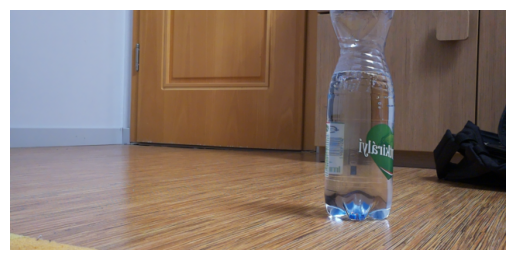

In [3]:
# take image
image = None

with Picamera2() as picam2:
  # picam2.preview_configuration.main.size = (1280, 720)
  picam2.preview_configuration.main.size = (640, 310)
  # picam2.preview_configuration.main.size = (640 /2, 310/2)

  picam2.preview_configuration.main.format = "BGR888"
  picam2.preview_configuration.align()
  picam2.preview_configuration.transform=Transform(vflip=1)
  picam2.configure("preview")
  picam2.start()

  image = picam2.capture_array()
  picam2.stop()
  picam2.stop_encoder()
  del picam2


# Display the captured image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [4]:


# small, base, 

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vits' # or 'vits', 'vitb'
dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 20 # 20 for indoor model, 80 for outdoor model

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
# download models from: 
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
model.eval()

# raw_img = cv2.imread('test_image.png')
raw_img = image

start_time = time.time()
original_depth = model.infer_image(raw_img) # HxW depth map in meters in numpy
end_time = time.time()

print(f"Inference time: {end_time - start_time} seconds")

depth = original_depth.copy()
depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
depth = depth.astype(np.uint8)
cmap = matplotlib.colormaps.get_cmap('Spectral')

depth = (cmap(depth)[:, :, :3] * 255)[:, :, ::-1].astype(np.uint8)

cv2.imwrite('depth_map.png', depth)


model_base = original_depth.copy()



/tmp/ipykernel_879491/342274689.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encod

Inference time: 23.495800018310547 seconds


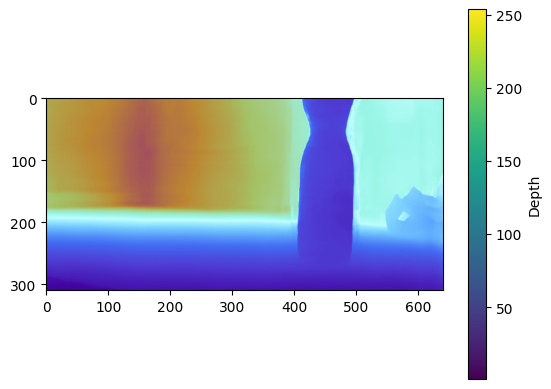

In [5]:
plt.imshow(depth)
plt.colorbar(label='Depth')

(310, 640)
Max depth: 2.2503817081451416


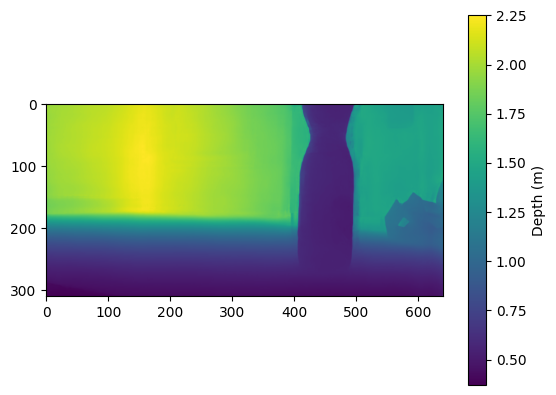

In [13]:
print(original_depth.shape)
# find largest value in orgianal depth 2d array
max_depth = np.max(original_depth)
print(f"Max depth: {max_depth}")
plt.imshow(original_depth)
plt.colorbar(label='Depth (m)')


In [7]:
print(original_depth.shape)

# HxW depth map in meters in numpy
# Height x Width 

def applyCorrection(meter): 
  meter = meter + 0.135
  # around 0.1, 0.2
  return meter * 100

print('Closer (cm)', applyCorrection(original_depth[200][310]))
# real: 0.72

print('Farther away (cm)', applyCorrection(original_depth[200][450]))
# real 0.95

# difference: 0.23

# print('Very far away', original_depth[10][410])



(310, 640)
Closer (cm) 140.66416120529175
Farther away (cm) 66.92448949813843
